In [1]:
# @title データの読み込み

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorentz_long_x.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Mounted at /content/drive


Data length: 1048575


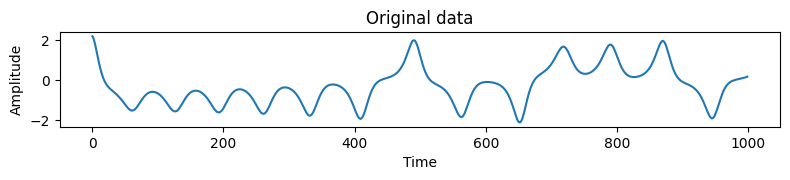

In [2]:
# @title データの読み込み・欠損値を削除・標準化

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv


# 欠損値のインデックスを特定する
nan_indices = np.where(np.isnan(data))

# 欠損値を削除した配列を作成する
data = np.delete(data, nan_indices)

# 平均と標準偏差の計算
mean_value = np.mean(data)
std_dev = np.std(data)

# 標準化
data = (data - mean_value) / std_dev


print('Data length:',data.size)

#######

t = np.arange(0, data.size, 1)  # 1秒間のサンプルデータ
# プロット
plt.figure(figsize=(8, 3))

# 時間領域のプロット
plt.subplot(2, 1, 1)
#plt.plot(t, data)   #change
plt.plot(data[:1000])   #change
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()



入力ゲート$i_t$、忘却ゲート$forget_t$と出力ゲート$o_t$バイアスは省略：
\begin{equation*}
\begin{split}
input_t&=f(W_{datain}d_t+W_{gatein}x_{t-1}),\\
forget_t&=f(W_{dataforget}d_t+W_{forget}x_{t-1}),\\
output_t&=f(W_{dataout}d_t+W_{gateout}x_{t-1}),\\
%\tilde c_t&=
\end{split}
\end{equation*}
メモリセル（CEC）
\begin{equation*}
cell_t=input_t\odot \tanh(W_{datacell}d_t+W_{cell}x_{t-1})+forget_t\odot c_{t-1}
\end{equation*}
隠れ層の出力：
\begin{equation*}
x_t=output_t\odot\tanh(cell_t)
\end{equation*}

 The operator $\odot$ denotes the Hadamard product (element-wise product).


units: LSTMセルのユニット数（特徴量の次元・隠れ状態ベクトル・リザバーベクトルに対応する）

input_shape: 入力データの形状を指定（ここではinput_shape=(timesteps, features)）

In [3]:
# @title トレーニング期間
T_train = 5000

In [4]:
# @title LSTM Kerasによる機械学習

%%time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K
import os
from contextlib import redirect_stdout

###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):
    # MAE（平均絶対誤差）を計算
    mae = mean_absolute_error(data1_in, data2_in)
    return mae



# RMSE関数の定義
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# ハイパーパラメータの設定
timesteps = 28  # 過去timesteps分のデータを使う (リザバーのdim*lagにおけるlag=1のときに対応)
features = 1    # データの次元（1次元時系列なら1）


# LSTM用にデータを整形する関数
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)


# データを整形
X_train, y_train = create_sequences(data[:T_train], timesteps)


CPU times: user 3.36 s, sys: 454 ms, total: 3.82 s
Wall time: 3.98 s


In [5]:
# @title モデル評価・平均化

%%time

#T_train はすでに定義している
Node = 70

trans_len = 10  # 学習しないステップ数（あまり重要ではない）

MAX_TRIALS = 8 #80
T_test = 100 # 予測期間

test_num = 3000  # 一回のテストに対する推定回数（一つのPCCを算出）
trans_len = 10  # 学習しないステップ数（あまり気にしなくて良い）
synchro_len=170
epochs = 20
batch_size =100

# 6. 繰り返し予測
mean_score  = []
score       = []

##########################################
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import regularizers
##########################################

for trial in range(MAX_TRIALS):
    print(f"Trial {trial + 1}/{MAX_TRIALS}")  # 試行回数を表示

    # モデルの構築


    model = Sequential([
    LSTM(units=70, input_shape=(timesteps, features)),  # ← 正則化なし
    Dense(
        1,
        kernel_regularizer=regularizers.l2(1e-4)  # ← Dense層のみ正則化
    )
    ])

    #model = Sequential([
    #    LSTM(units=70, input_shape=(timesteps, features)),
    #    Dense(1)  # 出力層
    #])

    # モデルのコンパイル
    #optimizer = SGD(learning_rate=0.001)  # 任意の固定学習率を指定
    #model.compile(optimizer=optimizer, loss=rmse)
    model.compile(optimizer='adam', loss=rmse)

    # 学習
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

#############

    #テストデータの初期化
    test_D = np.zeros((T_test,test_num))



    #正解データの生成
    for t in range(test_num):

        test_D[:,t] = data[T_train+t:T_train+t+T_test] # i列目は i*lag ステップ遅れた時系列


#############

    # 初期化
    predictions = np.zeros((T_test, test_num))

    # 各テスト系列の初期シーケンスを準備 (shape: test_num x timesteps x features)
    current_sequences = np.array([
        data[T_train + t - timesteps : T_train + t].reshape(timesteps, features)
        for t in range(test_num)
    ])

    for step in range(T_test):
        # 一括で予測
        with open(os.devnull, 'w') as f, redirect_stdout(f):
            pred = model.predict(current_sequences, verbose=0)  # shape: (test_num, 1)

        # 結果を保存
        predictions[step, :] = pred[:, 0]

        # シーケンス更新（古い値を削除し、新しい予測値を追加）
        current_sequences = np.concatenate([
            current_sequences[:, 1:, :],              # 過去t=1〜T-1 を前にずらす
            pred[:, np.newaxis, :]                    # shape: (test_num, 1, 1)
        ], axis=1)  # shape: (test_num, timesteps, features)

#############

    mae = MAE( predictions[T_test-1,:],test_D[T_test-1,:])

    score.append(mae)
    mean_score.append(np.mean(score))

    print('MAE:',mae)
    print('MAEの平均値:',np.mean(score))

Trial 1/8
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.4600
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0782
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0197
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0124
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0102
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0081
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0065
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0087
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0059
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0062
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0061
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0079
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0066
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0067
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0080
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.5044
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0737
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0182
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0113
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0099
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0077
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0103
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0073
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0070
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0062
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0065
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0076
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0083
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0067
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0053
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.5374
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0572
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0203
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0126
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0112
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0088
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0089
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0070
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0072
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0063
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0066
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0080
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0080
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0070
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0066
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.5737
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0922
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0234
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0126
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0103
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0086
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0088
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0076
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0068
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0065
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0081
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0068
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0072
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0060
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0074
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.5329
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0748
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0199
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0119
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0112
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0093
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0078
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0077
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0075
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0069
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0078
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0064
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0066
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0071
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0059
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.4551
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0545
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0173
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0112
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0100
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0095
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0062
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0066
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0076
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0075
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0072
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0065
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0069
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0062
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0057
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.4791
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0646
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0189
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0138
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0102
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0080
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0085
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0077
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0073
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0081
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0077
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0068
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0078
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0066
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0051
Epoch 16/20
50/

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.5987
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0733
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0195
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0131
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0108
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0079
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0083
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0076
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0080
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0077
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0071
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0078
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0065
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0069
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0064
Epoch 16/20
50/

MAEの平均値: 0.5216435250566315


/tmp/ipython-input-284607140.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()#loc='lower right')


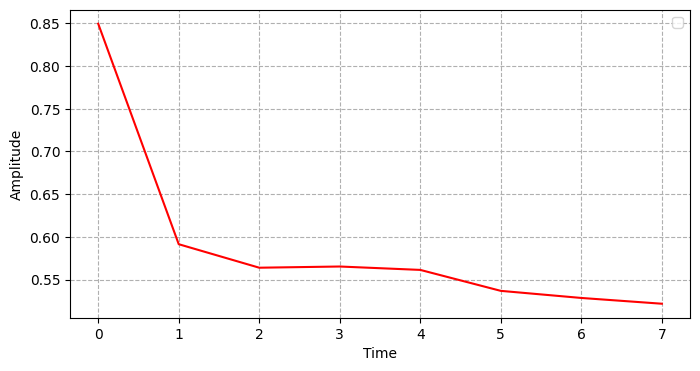

In [6]:
#se = np.array(se)
mean_score = np.array(mean_score)

import matplotlib.pyplot as plt

print('MAEの平均値:',mean_score[MAX_TRIALS-1])

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(mean_score, color = "red")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

MAE(the last trial): 0.47437711174381175
forecast period: 100


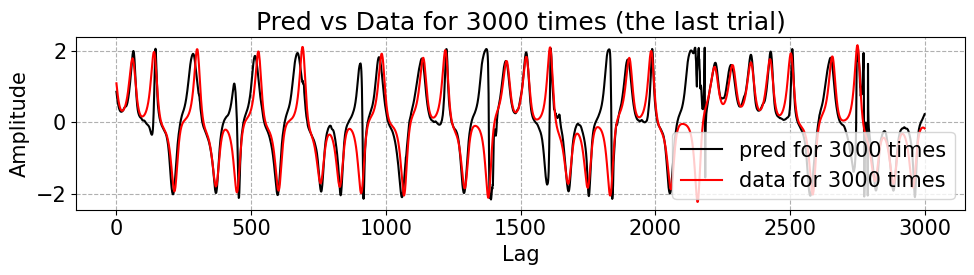

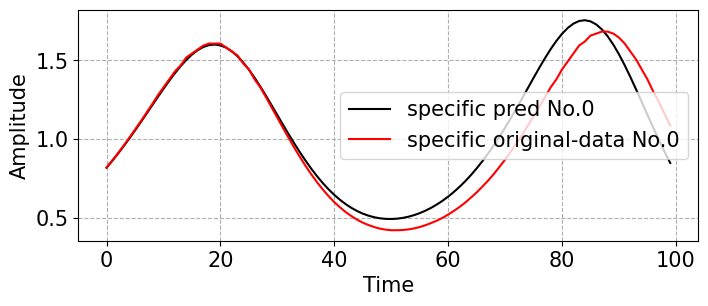

In [7]:
######################
######################

print("MAE(the last trial):", mae)
print("forecast period:", T_test)



fig = plt.figure(figsize=(10,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.title(f"Pred vs Data for {test_num} times (the last trial)")
plt.plot(predictions[T_test-1,:], color="black", label=f"pred for {test_num} times")
plt.plot(test_D[T_test-1,:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

#####################
T_fix = 0
#####################

# Running Test Predictions
plt.figure(figsize=(8, 3))
plt.plot(predictions[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific original-data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()